In [4]:
%load_ext autoreload
%autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from torchvision import transforms
from torchvision.datasets import MNIST
os.chdir("/nfs/students/winter-term-2020/project-4/schwienb/project-4")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.pixelcnn import PixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images, draw_likelihood_plot, positionalencoding2d, randomize_background_normal
from src.utils.ood_test import plot_roc_auc, test_ood, test_ood_coco
import torch.nn.functional as F
from src.models.coco_pixelcnn import COCOPixelCNN
from src.data.coco import COCODataModule
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import DataLoader, random_split
import cv2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [13]:
# PixelCNN_BGAUG02_RNBG_RC_COCO_01

experiment_name = 'PixelCNN_BgAugRandom_D32_G_COCO_4'

In [14]:
exp = Experiment(experiment_name)

In [15]:
# exp._setup()
exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [16]:
exp.model_params

{'concat_dataset': True,
 'bg_aug': True,
 'random_bg': True,
 'target_background': False}

In [17]:
transform = [
   transforms.Grayscale(num_output_channels=1), transforms.Resize((32,32), interpolation=Image.BICUBIC), 
    transforms.ToTensor()
]
transform = transforms.Compose(transform)

In [18]:
svhn_test = datasets.SVHN('data/', split='test', transform=transform, download=True)
_, svhn_test = torch.utils.data.random_split(svhn_test, [24332, 1700])
svhn_testloader = DataLoader(svhn_test, batch_size=1, shuffle=False, num_workers=10, drop_last=True, pin_memory=True)

Using downloaded and verified file: data/test_32x32.mat


In [19]:
def test_ood_coco(exp, idd, odd):
    exp.model.svhn = False
    idd_result = exp.trainer.test(exp.model, test_dataloaders=[idd], verbose=False)
    exp.model.svhn = True
    odd_result = exp.trainer.test(exp.model, test_dataloaders=[odd], verbose=False)
    exp.model.svhn = False
    
    idd_results = torch.Tensor(list(map(lambda x: x['test_loss'], idd_result))).numpy()
    odd_results = torch.Tensor(list(map(lambda x: x['test_loss'], odd_result))).numpy()

    targets = np.concatenate(
        (np.zeros(len(idd_results)), np.ones(len(odd_results))))
    results = np.concatenate((idd_results, odd_results))

    return (targets, results)

In [20]:
targets, results = test_ood_coco(exp, exp.dataset.test_dataloader(), svhn_testloader)


Set SLURM handle signals.


Set SLURM handle signals.


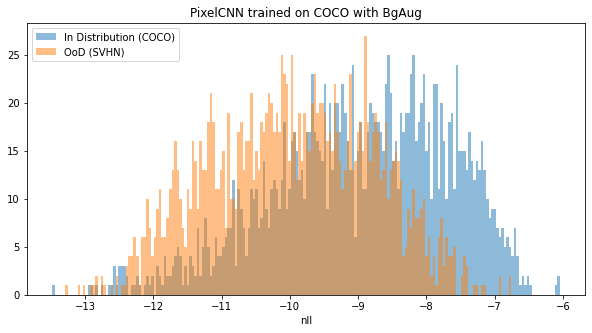

In [51]:
idd_losses = (results[:1751]) * -1
ood_losses = results[1752:] *-1

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (SVHN)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO with BgAug')
plt.show()

 ROC AUC=0.71808


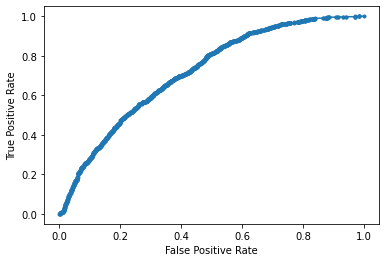

In [36]:
plot_roc_auc(targets, results)

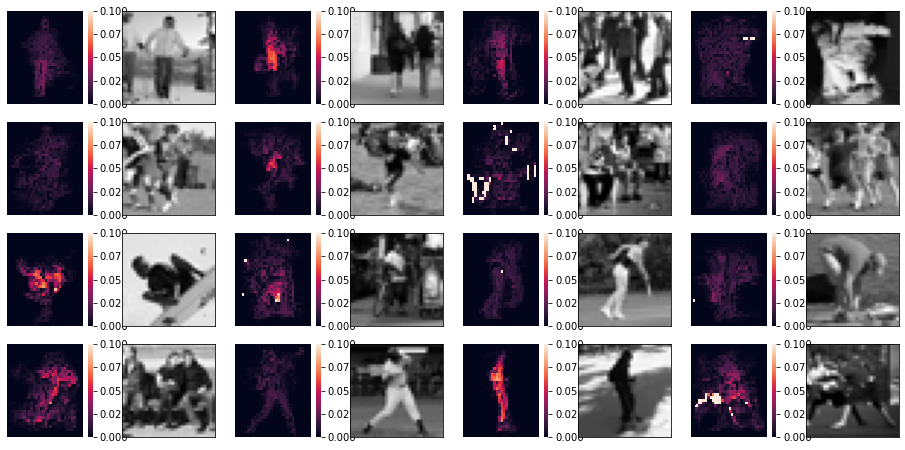

In [57]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model, cmap="rocket", vmax=0.1, img_index=0)

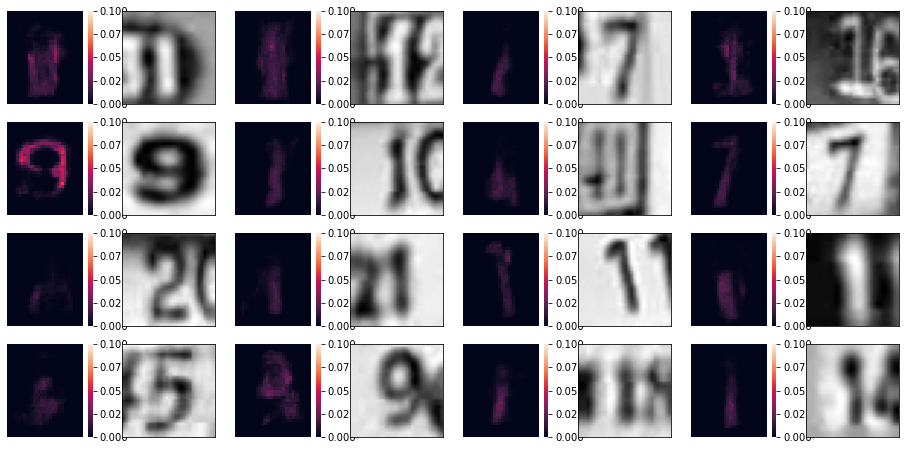

In [58]:
draw_likelihood_plot(svhn_testloader, exp.model, cmap="rocket", vmax=0.10, img_index=None)

## Test all models

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

In [10]:
models = [
    'PixelCNN_BGAUG02_RNBG_RC_COCO_01',
    'PixelCNN_BgAugRandom_RNBGT_D32_G_RC_COCO_1', 
    'PixelCNN_BgAugRandom01_TargRandom_D32_G_RC_30E_COCO_1', 
    'PixelCNN_BgAugRandom02_TargRandom_D32_G_RC_10E_COCO_1',
    'PixelCNN_BgAugRandom01_TargRandom_D32_G_RC_10E_COCO_1',
    'PixelCNN_BgAugRandom02_TargRandom_D32_G_RC_COCO_1',
    'PixelCNN_BgAugRandom_TargRandom_D32_G_RC_COCO_1',
    'PixelCNN_BgAugRandom_D32_G_RC_COCO_1',
    'PixelCNN_BgSub_TargFg_D32_G_30E_COCO_1',
    'PixelCNN_BgAugRandomNormal_TargRandomNormal_D32_G_30E_COCO_1',
    'PixelCNN_BgAug_MSE_D32_G_COCO_1',
    'PixelCNN_BgAugRandomNormal_TargRandomNormal_D32_G_COCO_1',
    'PixelCNN_BgAugRandom_TargRandom_S_D32_G_COCO_1',
    'PixelCNN_BgAugRandom_S_D32_G_COCO_1',
    'PixelCNN_BgAugRandom_TargRand_D32_G_COCO_1',
    'PixelCNN_BgAugRandom_D32_G_COCO_4',
    'PixelCNN_BgAugRandom_D32_G_COCO_3',
    'PixelCNN_BgAugRandomNormal_D32_G_20E_COCO_1',
    'PixelCNN_BgAugRandomNormal_D32_G_COCO_1',
    'PixelCNN_BgAugRandom_D32_G_TargBg_COCO_1',
    'PixelCNN_BgAugRandom_D32_G_COCO_1'
    'PixelCNN_BgAug_D32_G_COCO_2',
    'PixelCNN_BgAug_D32_G_100E_COCO_1',
    'PixelCNN_BgAug_D32_G_COCO_1'
]

In [11]:
result = {}
for model in models:
    try:
        exp = Experiment(model)
        exp.load()

        targets, results = test_ood_coco(exp, exp.dataset.test_dataloader(), svhn_testloader)
        auc = roc_auc_score(targets, results)
        print(auc)
        
        result[model] = auc
        del exp
    except:
        print(model, 'error')
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.4218615359216577


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5631551679243206


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5184712054955587


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5685666368695288


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5733791430772659


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5783919746375352


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.43513149664849304


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.29077711472434964


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgSub_TargFg_D32_G_30E_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgAugRandomNormal_TargRandomNormal_D32_G_30E_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.7031300752444842


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgAugRandomNormal_TargRandomNormal_D32_G_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.47035788778558946


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgAugRandom_S_D32_G_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.3909914662070928


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.7205488176442008


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.38474480496296837


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgAugRandomNormal_D32_G_20E_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


PixelCNN_BgAugRandomNormal_D32_G_COCO_1 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.5379896730099673
PixelCNN_BgAugRandom_D32_G_COCO_1PixelCNN_BgAug_D32_G_COCO_2 error


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.27969747851787424


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Set SLURM handle signals.



0.27011071918479324


In [12]:
result

{'PixelCNN_BGAUG02_RNBG_RC_COCO_01': 0.4218615359216577,
 'PixelCNN_BgAugRandom_RNBGT_D32_G_RC_COCO_1': 0.5631551679243206,
 'PixelCNN_BgAugRandom01_TargRandom_D32_G_RC_30E_COCO_1': 0.5184712054955587,
 'PixelCNN_BgAugRandom02_TargRandom_D32_G_RC_10E_COCO_1': 0.5685666368695288,
 'PixelCNN_BgAugRandom01_TargRandom_D32_G_RC_10E_COCO_1': 0.5733791430772659,
 'PixelCNN_BgAugRandom02_TargRandom_D32_G_RC_COCO_1': 0.5783919746375352,
 'PixelCNN_BgAugRandom_TargRandom_D32_G_RC_COCO_1': 0.43513149664849304,
 'PixelCNN_BgAugRandom_D32_G_RC_COCO_1': 0.29077711472434964,
 'PixelCNN_BgAug_MSE_D32_G_COCO_1': 0.7031300752444842,
 'PixelCNN_BgAugRandom_TargRandom_S_D32_G_COCO_1': 0.47035788778558946,
 'PixelCNN_BgAugRandom_TargRand_D32_G_COCO_1': 0.3909914662070928,
 'PixelCNN_BgAugRandom_D32_G_COCO_4': 0.7205488176442008,
 'PixelCNN_BgAugRandom_D32_G_COCO_3': 0.38474480496296837,
 'PixelCNN_BgAugRandom_D32_G_TargBg_COCO_1': 0.5379896730099673,
 'PixelCNN_BgAug_D32_G_100E_COCO_1': 0.27969747851787424